In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import textacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm_notebook

In [54]:
#Plan:
# Ask Christoph why I am getting different results to those in 'modelling'
# Show him bottom of the page
# Maybe look into the predictive power of only positive/negative tweets
# Then with above, add conditional on existence of 'buzzword' found from most impactful
# words on price movement

In [55]:
sents = pd.read_csv('./datasets/word_sentiments.csv')

In [56]:
## Add the stop-words here in the sen_dict? ##

## Create the `sen_dict` from the word_sentiments data frame

In [57]:
from collections import defaultdict
sen_dict = defaultdict(dict) # set up a default dictionary with an empty dictionary as default value

for row in tqdm_notebook(sents.itertuples()):
    sen_dict[row.pos] [row.word] = {'objectivity': row.objectivity, 'pos_vs_neg': row.pos_vs_neg}

## Complete sentiment analysis manually using the sentiment dictionary

In [58]:
en_nlp = textacy.load_spacy_lang('en_core_web_sm')

In [59]:
## ADDING STOPWORDS HERE IF POSSIBLE... ##

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction import text

In [61]:
# from nltk.corpus import stopwords
# stop = stopwords.words('english')
# stop += ['http', 'https', 'realdonaldtrump', 'co', 'hilary', 'crooked', 'trump2016', 'make america great'\
#         'maga', 'amp']

In [62]:
def process_text(documents, pos=False):
    nlp = textacy.load_spacy_lang('en_core_web_sm')
    
    texts = []
    tokenised_texts = []

    if pos: # pos can either be False or a list of parts of speech
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ in pos
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
    
    
    else:    
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
            
    return texts, tokenised_texts

In [63]:
pos = ['NOUN', 'ADJ', 'VERB', 'ADV']

In [64]:
trump_nlp = pd.read_csv('ripe_for_nlp.csv')

In [65]:
processed_titles, tokenised_titles = process_text(trump_nlp['text'], pos=pos)

In [66]:
trump_nlp.index = trump_nlp['Unnamed: 0']

In [67]:
trump_nlp['processed_title'] = processed_titles
trump_nlp['tokenised_title'] = tokenised_titles

In [143]:
trump_nlp.shape

(7571, 75)

In [69]:
trump_nlp[trump_nlp.processed_title.str.contains(r'hilary|crooked|trump2016')]

,Unnamed: 0,text,vol_pct_ch,volume_-5,volume_-4,volume_-3,volume_-2,volume_-1,volume_0,volume_1,...,mean_daily_volume,mean_hourly_value,mean_hourly_value_total,Vol_ch_abs,vol_45_avg,sustained_vol,pct_ch_sig,tweet_length,processed_title,tokenised_title
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2016-01-25 04:04:00+00:00,2016-01-25 04:04:00+00:00,"""@Knight276: @C4Constitution trump right agai...",-80.416667,40.0,101.0,279.0,220.0,240.0,47,92.0,...,1192.050549,110.000000,99.290780,80.416667,108.804348,1.095815,0,12,@C4Constitution trump right With_Cruz_you_lose...,"[@C4Constitution, trump, right, With_Cruz_you_..."
2016-03-07 02:58:00+00:00,2016-03-07 02:58:00+00:00,How do you fight millions of dollars of fraudu...,-47.126437,67.0,66.0,536.0,195.0,174.0,92,119.0,...,1146.796921,116.550000,114.818396,47.126437,80.739130,0.703190,0,22,How fight millions dollars fraudulent commerci...,"[How, fight, millions, dollars, fraudulent, co..."
2016-05-06 10:14:00+00:00,2016-05-06 10:14:00+00:00,"Unlike crooked Hillary Clinton, who wants to d...",-23.857868,120.0,123.0,238.0,63.0,197.0,150,425.0,...,1378.230415,237.350000,242.662469,23.857868,351.282609,1.447618,1,26,crooked wants destroy miners want wages bringi...,"[crooked, wants, destroy, miners, want, wages,..."
2016-05-10 19:31:00+00:00,2016-05-10 19:31:00+00:00,The Clintons spend millions on negative ads on...,-70.539097,4252.0,2440.0,4848.0,1382.0,11612.0,3421,3254.0,...,1016.586081,1321.600000,3111.245946,70.539097,4418.608696,1.420206,-1,24,spend millions negative ads amp n’t tell truth...,"[spend, millions, negative, ads, amp, n’t, tel..."
2016-05-11 19:37:00+00:00,2016-05-11 19:37:00+00:00,Goofy Elizabeth Warren is now using the woman’...,-16.807995,6108.0,2286.0,2130.0,3015.0,3302.0,2747,2647.0,...,1070.087436,2504.250000,3111.245946,16.807995,5320.869565,1.710205,0,25,woman card friend crooked See dumb tweet woman...,"[woman, card, friend, crooked, See, dumb, twee..."
2016-07-19 13:36:00+00:00,2016-07-19 13:36:00+00:00,"""@RoxaneTancredi: Democrats are coming to TRU...",30.092593,9490.0,6556.0,5729.0,6440.0,5400.0,7025,6160.0,...,845.867994,580.216667,1971.048193,30.092593,5042.565217,2.558317,1,25,@RoxaneTancredi coming TRUMP proud dem party N...,"[@RoxaneTancredi, coming, TRUMP, proud, dem, p..."
2016-11-22 02:14:00+00:00,2016-11-22 02:14:00+00:00,Prior to the election it was well known that I...,-82.388974,56.0,51.0,171.0,183.0,653.0,115,213.0,...,911.278063,226.283333,114.818396,82.388974,216.152174,1.882557,-1,26,Prior election known interests properties worl...,"[Prior, election, known, interests, properties..."
2017-01-11 12:44:00+00:00,2017-01-11 12:44:00+00:00,"I win an election easily, a great ""movement"" i...",91.071429,370.0,105.0,334.0,356.0,280.0,535,830.0,...,1279.830370,279.216667,557.257844,91.071429,278.956522,0.500588,-1,24,win election easily great movement verified cr...,"[win, election, easily, great, movement, verif..."
2017-04-03 10:15:00+00:00,2017-04-03 10:15:00+00:00,Such amazing reporting on unmasking and the cr...,42.857143,6.0,2090.0,196.0,8.0,231.0,330,282.0,...,1244.074156,141.083333,242.662469,42.857143,186.326087,0.767841,0,20,Such amazing reporting unmasking crooked schem...,"[Such, amazing, reporting, unmasking, crooked,..."


In [70]:
stop = set(ENGLISH_STOP_WORDS)
my_additional_stop_words = ['http', 'https', 'realdonaldtrump', 'co', 'trump2016','maga', 'amp']
stop = set(ENGLISH_STOP_WORDS)
stop = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [71]:
def scorer(parsed):
    
    obj_scores, pvn_scores = [], []
    
    for token in parsed:
        try:
            obj_scores.append(sen_dict[token.pos_][token.lemma_]['objectivity'])
            pvn_scores.append(sen_dict[token.pos_][token.lemma_]['pos_vs_neg'])
        except:
            pass
    
    if not obj_scores:
        obj_scores = [1.]
    if not pvn_scores:
        pvn_scores = [0.]
        
    return [np.mean(obj_scores), np.mean(pvn_scores)]

In [72]:
scores = trump_nlp['tokenised_title'].map(scorer)
trump_nlp['objectivity_avg'] = scores.map(lambda x: x[0])
trump_nlp['polarity_avg'] = scores.map(lambda x: x[1])

In [73]:
trump_nlp.columns

Index(['Unnamed: 0', 'text', 'vol_pct_ch', 'volume_-5', 'volume_-4',
       'volume_-3', 'volume_-2', 'volume_-1', 'volume_0', 'volume_1',
       'volume_2', 'volume_3', 'volume_4', 'volume_5', 'volume_6', 'volume_7',
       'volume_8', 'volume_9', 'volume_10', 'volume_11', 'volume_12',
       'volume_13', 'volume_14', 'volume_15', 'volume_16', 'volume_17',
       'volume_18', 'volume_19', 'volume_20', 'volume_21', 'volume_22',
       'volume_23', 'volume_24', 'volume_25', 'volume_26', 'volume_27',
       'volume_28', 'volume_29', 'volume_30', 'volume_31', 'volume_32',
       'volume_33', 'volume_34', 'volume_35', 'volume_36', 'volume_37',
       'volume_38', 'volume_39', 'volume_40', 'volume_41', 'volume_42',
       'volume_43', 'volume_44', 'volume_45', 'O-C-diff', 'O-C1-diff',
       'O-C-5-diff', 'O-C-10-diff', 'O-C-60-diff', 'mean_daily_volume',
       'mean_hourly_value', 'mean_hourly_value_total', 'Vol_ch_abs',
       'vol_45_avg', 'sustained_vol', 'pct_ch_sig', 'tweet_length',


In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

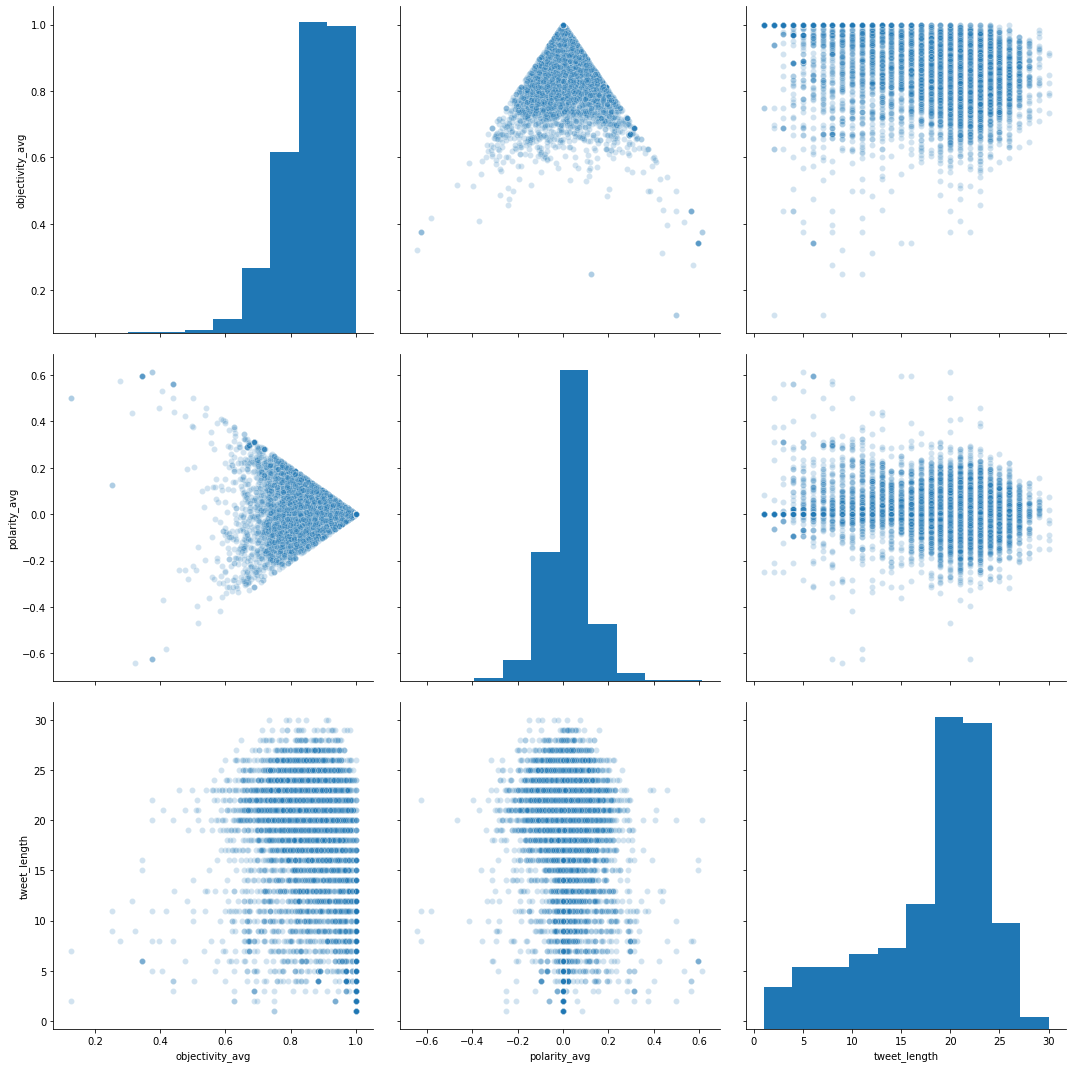

In [75]:
sns.pairplot(trump_nlp, vars=['objectivity_avg', 'polarity_avg', 'tweet_length'], 
             plot_kws={'alpha': 0.2}, height=5)
plt.show();

In [76]:
trump_nlp.head()

,Unnamed: 0,text,vol_pct_ch,volume_-5,volume_-4,volume_-3,volume_-2,volume_-1,volume_0,volume_1,...,mean_hourly_value_total,Vol_ch_abs,vol_45_avg,sustained_vol,pct_ch_sig,tweet_length,processed_title,tokenised_title,objectivity_avg,polarity_avg
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2016-01-03 23:18:00+00:00,2016-01-03 23:18:00+00:00,The worst thing Hillary could do is have her h...,-69.583333,103.0,117.0,70.0,94.0,480.0,146,86.0,...,98.211940,69.583333,99.695652,1.015107,-1,15,worst thing husband campaign Just watch,"[worst, thing, husband, campaign, Just, watch]",0.831845,-0.075397
2016-01-03 23:19:00+00:00,2016-01-03 23:19:00+00:00,"By the way, Hillary &amp; the MSM forgot to me...",-41.095890,117.0,70.0,94.0,480.0,146.0,86,89.0,...,98.211940,41.095890,100.826087,1.026617,-1,19,way amp forgot mention terror video,"[way, amp, forgot, mention, terror, video]",0.888889,-0.045139
2016-01-04 00:26:00+00:00,2016-01-04 00:26:00+00:00,"""@icareeguns: This #Iowan is voting for @RealD...",280.769231,8.0,36.0,45.0,171.0,26.0,99,172.0,...,164.021858,280.769231,84.586957,0.515705,-1,17,@icareeguns voting @RealDonaldTrump Thank supp...,"[@icareeguns, voting, @RealDonaldTrump, Thank,...",0.827765,0.141174
2016-01-04 11:42:00+00:00,2016-01-04 11:42:00+00:00,"""@RhettRiley1234: Trump only wins with our vot...",-40.952381,619.0,1862.0,2584.0,881.0,735.0,434,822.0,...,319.865325,40.952381,638.891304,1.997376,1,21,@RhettRiley1234 wins votes grow nation vote time,"[@RhettRiley1234, wins, votes, grow, nation, v...",0.944792,0.055208
2016-01-04 17:31:00+00:00,2016-01-04 17:31:00+00:00,"I look forward to being in Lowell, Massachuset...",25.345377,3469.0,1532.0,1366.0,3924.0,1882.0,2359,1836.0,...,1794.858006,25.345377,2636.369565,1.468846,-1,22,look forward today hear big crowd expected lot...,"[look, forward, today, hear, big, crowd, expec...",0.885885,0.015942


## Build a classification model to predict if the S&P moved up or down

I am using a Random Forest Model, but if you have time do try others!!

In [77]:
trump_nlp.shape

(7571, 71)

In [78]:
# baseline

trump_nlp['pct_ch_sig'].value_counts()

 0    3738
 1    1947
-1    1886
Name: pct_ch_sig, dtype: int64

In [79]:
trump_nlp['pct_ch_sig'].value_counts(normalize=True)

 0    0.493726
 1    0.257165
-1    0.249108
Name: pct_ch_sig, dtype: float64

In [80]:
X = trump_nlp[['objectivity_avg', 'polarity_avg', 'tweet_length']].astype(float)
y = trump_nlp['pct_ch_sig']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [82]:
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [83]:
rf = RandomForestClassifier(n_estimators=100)

params = {
    'criterion': ['entropy', 'gini'],
    'max_features': np.linspace(0.1,1.0, 20),
}

gs = GridSearchCV(rf, params, n_jobs=-1, cv=5, verbose=1, iid=False)
gs.fit(X_train_s, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'criterion': ['entropy', 'gini'], 'max_features': array([0.1    , 0.14737, 0.19474, 0.24211, 0.28947, 0.33684, 0.38421,
       0.43158, 0.47895, 0.52632, 0.57368, 0.62105, 0.66842, 0.71579,
       0.76316, 0.81053, 0.85789, 0.90526, 0.95263, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [84]:
gs.score(X_train_s, y_train)

0.9392338177014531

In [85]:
gs.score(X_test_s, y_test)

0.4099009900990099

In [86]:
gs.best_params_

{'criterion': 'entropy', 'max_features': 0.33684210526315794}

In [87]:
predictions_train = gs.predict(X_train_s)
predictions_test = gs.predict(X_test_s)

## Evaluate your model with a classification report and confusion matrix

Describe your results!

In [88]:
print(classification_report(y_train, predictions_train))

              precision    recall  f1-score   support

          -1       0.94      0.91      0.92      1509
           0       0.94      0.97      0.95      2990
           1       0.94      0.92      0.93      1557

   micro avg       0.94      0.94      0.94      6056
   macro avg       0.94      0.93      0.93      6056
weighted avg       0.94      0.94      0.94      6056



In [89]:
pd.DataFrame(confusion_matrix(y_train, predictions_train),
             index=['significant fall', 'insignificant','significant rise'],
             columns=['predicted significant fall', 'predicted insignificant', 'predicted significant rise'])

,predicted significant fall,predicted insignificant,predicted significant rise
significant fall,1369,102,38
insignificant,50,2889,51
significant rise,37,90,1430


In [90]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

          -1       0.28      0.20      0.24       377
           0       0.50      0.64      0.56       748
           1       0.23      0.17      0.19       390

   micro avg       0.41      0.41      0.41      1515
   macro avg       0.34      0.34      0.33      1515
weighted avg       0.38      0.41      0.39      1515



In [91]:
pd.DataFrame(confusion_matrix(y_test, predictions_test),
             index=['significant fall', 'insignificant','significant rise'],
             columns=['predicted significant fall', 'predicted insignificant', 'predicted significant rise'])

,predicted significant fall,predicted insignificant,predicted significant rise
significant fall,77,227,73
insignificant,128,479,141
significant rise,67,258,65


## Do steps 1 to 3 using the VADER Sentiment Analyzer

### Complete sentiment analysis using VADER

In [92]:
analyzer = SentimentIntensityAnalyzer()

In [93]:
vader_scores = trump_nlp['text'].map(analyzer.polarity_scores)

In [94]:
vader_scores.head()

Unnamed: 0
2016-01-03 23:18:00+00:00    {'neg': 0.227, 'neu': 0.773, 'pos': 0.0, 'comp...
2016-01-03 23:19:00+00:00    {'neg': 0.159, 'neu': 0.841, 'pos': 0.0, 'comp...
2016-01-04 00:26:00+00:00    {'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound...
2016-01-04 11:42:00+00:00    {'neg': 0.0, 'neu': 0.844, 'pos': 0.156, 'comp...
2016-01-04 17:31:00+00:00    {'neg': 0.0, 'neu': 0.834, 'pos': 0.166, 'comp...
Name: text, dtype: object

In [95]:
from sklearn.feature_extraction import DictVectorizer

dvec = DictVectorizer()

vader_scores = dvec.fit_transform(vader_scores)
vader_scores

<7571x4 sparse matrix of type '<class 'numpy.float64'>'
	with 30284 stored elements in Compressed Sparse Row format>

In [96]:
dvec.feature_names_

['compound', 'neg', 'neu', 'pos']

In [97]:
for i, col in enumerate(dvec.feature_names_):
    trump_nlp['vader_{}'.format(col)] = vader_scores[:, i].toarray().ravel()

In [137]:
trump_nlp[trump_nlp.text.str.contains(r'London')]

,Unnamed: 0,text,vol_pct_ch,volume_-5,volume_-4,volume_-3,volume_-2,volume_-1,volume_0,volume_1,...,pct_ch_sig,tweet_length,processed_title,tokenised_title,objectivity_avg,polarity_avg,vader_compound,vader_neg,vader_neu,vader_pos
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2016-02-08 19:43:00+00:00,2016-02-08 19:43:00+00:00,"Today's third stop- Londonderry, New Hampshire...",37.882798,1956.0,3080.0,2898.0,1658.0,5290.0,7294,4484.0,...,1,11,Today stop- Thank # https://t.co/pRpcxaZ7ov,"[Today, stop-, Thank, #, https://t.co/pRpcxaZ7ov]",0.968750,0.031250,0.2225,0.154,0.630,0.216
2017-03-23 01:33:00+00:00,2017-03-23 01:33:00+00:00,Spoke to U.K. Prime Minister Theresa May today...,-15.430267,44.0,43.0,126.0,185.0,337.0,285,37.0,...,-1,24,Spoke May today offer condolences terrorist at...,"[Spoke, May, today, offer, condolences, terror...",0.813479,0.016150,-0.4779,0.233,0.597,0.170
2017-03-23 15:16:00+00:00,2017-03-23 15:16:00+00:00,"A great American, Kurt Cochran, was killed in ...",171.915641,5766.0,2239.0,3692.0,8081.0,2845.0,7736,9128.0,...,1,22,great killed terror attack My prayers condolen...,"[great, killed, terror, attack, My, prayers, c...",0.785851,0.012934,-0.5859,0.322,0.468,0.211
2017-06-05 13:49:00+00:00,2017-06-05 13:49:00+00:00,Pathetic excuse by London Mayor Sadiq Khan who...,18.145059,2916.0,3306.0,4590.0,2382.0,3957.0,4675,4130.0,...,1,27,Pathetic excuse think fast reason alarmed stat...,"[Pathetic, excuse, think, fast, reason, alarme...",0.787944,-0.078513,-0.8268,0.300,0.661,0.039
2017-09-15 10:42:00+00:00,2017-09-15 10:42:00+00:00,Another attack in London by a loser terrorist....,-94.267516,339.0,368.0,286.0,228.0,471.0,27,23.0,...,0,24,attack loser terrorist sick demented people si...,"[attack, loser, terrorist, sick, demented, peo...",0.779266,-0.161210,-0.8070,0.316,0.596,0.088
2017-09-15 20:54:00+00:00,2017-09-15 20:54:00+00:00,Our hearts &amp; prayers go out to the people ...,4.545455,456.0,21.0,509.0,380.0,616.0,644,267.0,...,0,18,Our hearts amp prayers people suffered vicious...,"[Our, hearts, amp, prayers, people, suffered, ...",0.761469,-0.162142,-0.8860,0.426,0.574,0.000
2018-01-12 04:57:00+00:00,2018-01-12 04:57:00+00:00,Reason I canceled my trip to London is that I ...,-96.153846,247.0,7.0,78.0,177.0,26.0,1,95.0,...,0,24,canceled trip big fan having sold https://t.co...,"[canceled, trip, big, fan, having, sold, https...",0.868626,-0.004164,-0.2411,0.089,0.911,0.000
2018-08-14 11:42:00+00:00,2018-08-14 11:42:00+00:00,Another terrorist attack in London...These ani...,-43.027888,108.0,100.0,199.0,426.0,251.0,143,143.0,...,0,17,terrorist attack animals crazy dealt toughness...,"[terrorist, attack, animals, crazy, dealt, tou...",0.717593,-0.078472,-0.8172,0.435,0.446,0.119
2019-06-03 07:51:00+00:00,2019-06-03 07:51:00+00:00,".@SadiqKhan, who by all accounts has done a te...",43.692870,486.0,630.0,1448.0,896.0,547.0,786,941.0,...,0,22,accounts terrible job foolishly nasty visi htt...,"[accounts, terrible, job, foolishly, nasty, vi...",0.513173,-0.397981,-0.7096,0.237,0.763,0.000


In [99]:
## Run another model on vader scores to classify ##

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

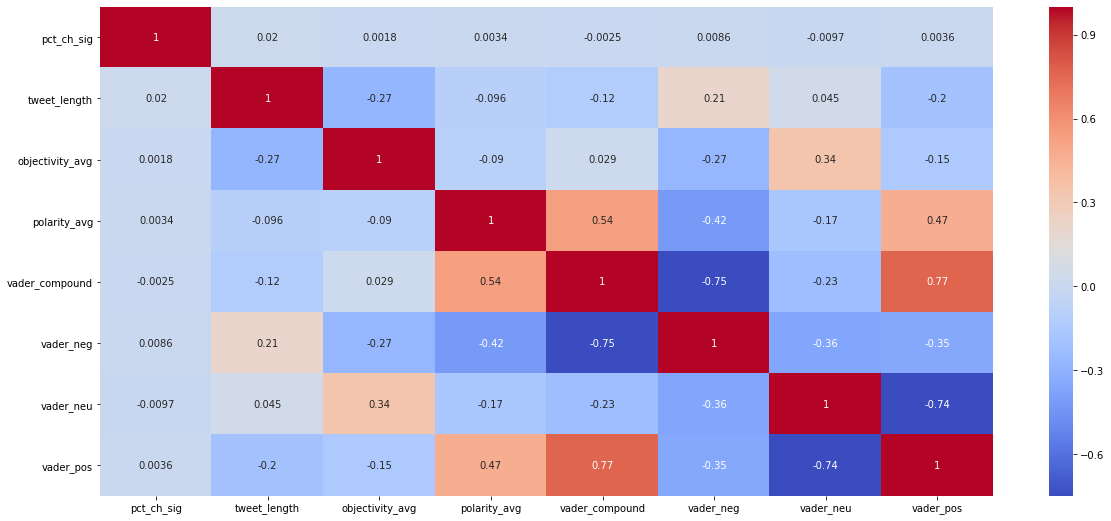

In [101]:
corrs = trump_nlp[['pct_ch_sig', 'tweet_length', 'objectivity_avg','polarity_avg', \
                   'vader_compound','vader_neg', 'vader_neu', 'vader_pos']].corr()
fig, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrs, annot=True, cmap='coolwarm');

In [102]:
import re

In [103]:
trump_nlp_test = trump_nlp[trump_nlp.text.str.contains(r'Chin|trade|tarrif|Kim|Korea|rocketman|hue|nafta|steel|Fed|federal reserve \
            |Powell|dollar|currency|oil|saudi|OPEC|Middle East|Mexic|peso|Xi|amazon', flags=re.IGNORECASE)]

In [104]:
trump_nlp_test['pct_ch_sig'].value_counts(normalize=True)

 0    0.531677
 1    0.236025
-1    0.232298
Name: pct_ch_sig, dtype: float64

In [105]:
trump_nlp_crooked = trump_nlp[trump_nlp.text.str.contains(r'crooked|fake', flags=re.IGNORECASE)]

In [106]:
trump_nlp_crooked['pct_ch_sig'].value_counts(normalize=True)

 0    0.477612
 1    0.304904
-1    0.217484
Name: pct_ch_sig, dtype: float64

In [107]:
trump_nlp_stop = trump_nlp[~trump_nlp.text.str.contains(r'interviewed|harassment|job\
|flotus|september11th|neverforget|prayers',flags=re.IGNORECASE)]

In [108]:
trump_nlp.columns

Index(['Unnamed: 0', 'text', 'vol_pct_ch', 'volume_-5', 'volume_-4',
       'volume_-3', 'volume_-2', 'volume_-1', 'volume_0', 'volume_1',
       'volume_2', 'volume_3', 'volume_4', 'volume_5', 'volume_6', 'volume_7',
       'volume_8', 'volume_9', 'volume_10', 'volume_11', 'volume_12',
       'volume_13', 'volume_14', 'volume_15', 'volume_16', 'volume_17',
       'volume_18', 'volume_19', 'volume_20', 'volume_21', 'volume_22',
       'volume_23', 'volume_24', 'volume_25', 'volume_26', 'volume_27',
       'volume_28', 'volume_29', 'volume_30', 'volume_31', 'volume_32',
       'volume_33', 'volume_34', 'volume_35', 'volume_36', 'volume_37',
       'volume_38', 'volume_39', 'volume_40', 'volume_41', 'volume_42',
       'volume_43', 'volume_44', 'volume_45', 'O-C-diff', 'O-C1-diff',
       'O-C-5-diff', 'O-C-10-diff', 'O-C-60-diff', 'mean_daily_volume',
       'mean_hourly_value', 'mean_hourly_value_total', 'Vol_ch_abs',
       'vol_45_avg', 'sustained_vol', 'pct_ch_sig', 'tweet_length',


## Run model again with new stopwords

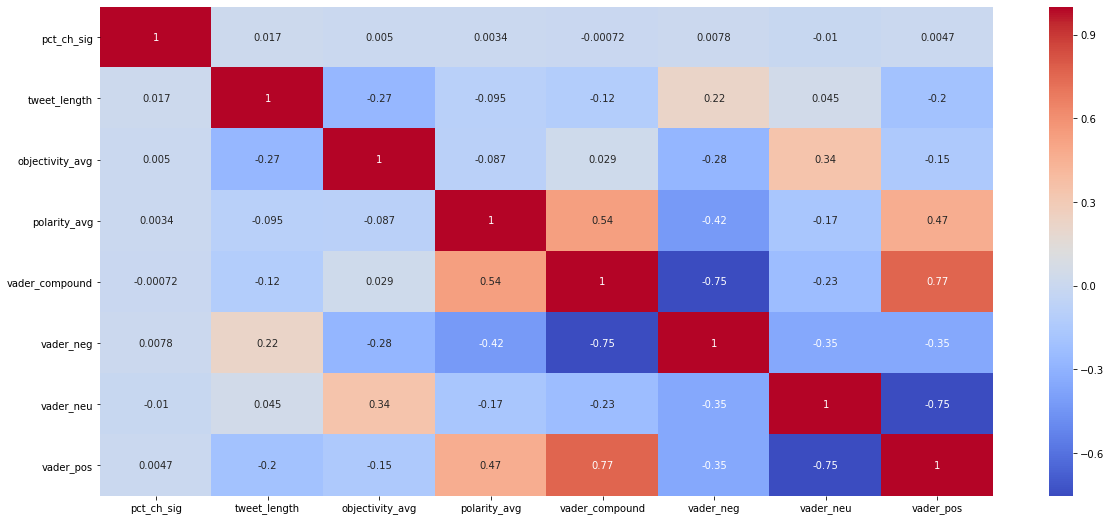

In [109]:
corrs = trump_nlp_stop[['pct_ch_sig', 'tweet_length', 'objectivity_avg','polarity_avg', \
                   'vader_compound','vader_neg', 'vader_neu', 'vader_pos']].corr()
fig, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrs, annot=True, cmap='coolwarm');

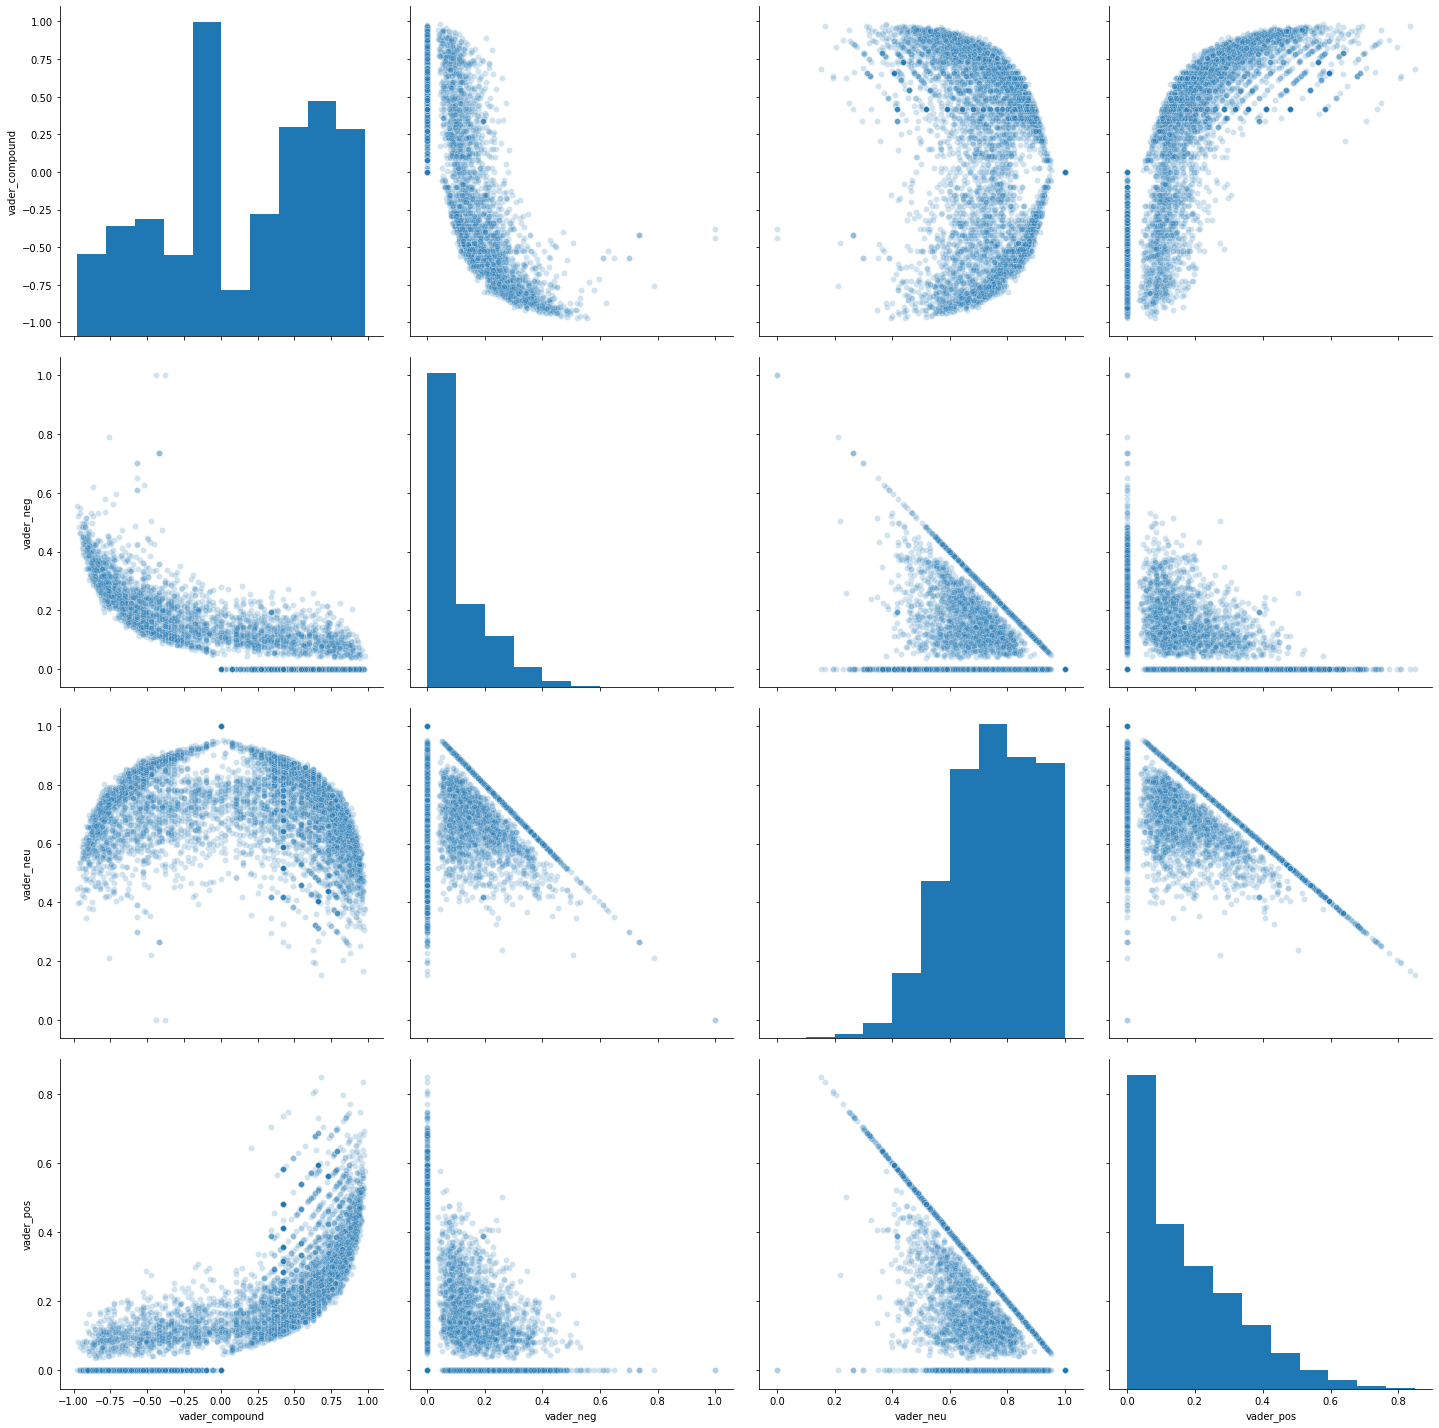

In [139]:
sns.pairplot(trump_nlp_stop, vars=['vader_compound', 'vader_neg', 'vader_neu', 'vader_pos'], 
             plot_kws={'alpha': 0.2}, height=5)
plt.show();

In [133]:
trump_nlp[['text','vader_neu']]

,text,vader_neu
Unnamed: 0,,
2016-01-03 23:18:00+00:00,The worst thing Hillary could do is have her h...,0.773
2016-01-03 23:19:00+00:00,"By the way, Hillary &amp; the MSM forgot to me...",0.841
2016-01-04 00:26:00+00:00,"""@icareeguns: This #Iowan is voting for @RealD...",0.500
2016-01-04 11:42:00+00:00,"""@RhettRiley1234: Trump only wins with our vot...",0.844
2016-01-04 17:31:00+00:00,"I look forward to being in Lowell, Massachuset...",0.834
2016-01-04 20:00:00+00:00,"Woody Johnson, owner of the NYJets, is @JebBus...",1.000
2016-01-05 02:20:00+00:00,"The rally in Lowell, Massachusetts, was amazin...",0.593
2016-01-05 02:22:00+00:00,"""@troyconway: Now 2-more IT Firms going over s...",0.726
2016-01-05 02:28:00+00:00,"""@thecybermenace: @realDonaldTrump Donald Trum...",1.000


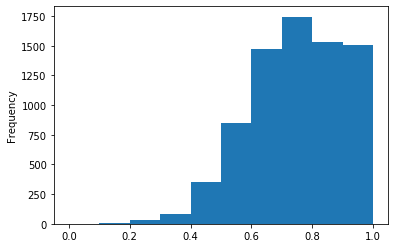

In [131]:
trump_nlp['vader_neu'].plot(kind='hist')

In [111]:
trump_nlp_test.pct_ch_sig.value_counts(normalize=True).max()

0.5316770186335403

In [114]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

In [ ]:
# merge with pricing and have a look at the scores? maybe only include strongest correlations in the new cor
# matrix

In [ ]:
# Add CV scores into above model

In [142]:
trump_nlp_stop[['mean_hourly_value', 'mean_hourly_value_total', 'Vol_ch_abs',
       'vol_45_avg', 'sustained_vol', 'pct_ch_sig']].corr()

,mean_hourly_value,mean_hourly_value_total,Vol_ch_abs,vol_45_avg,sustained_vol,pct_ch_sig
mean_hourly_value,1.000000,0.769115,-0.100893,0.700636,0.106385,0.005400
mean_hourly_value_total,0.769115,1.000000,-0.114246,0.688185,-0.043771,-0.003470
Vol_ch_abs,-0.100893,-0.114246,1.000000,-0.102727,-0.045307,-0.002551
vol_45_avg,0.700636,0.688185,-0.102727,1.000000,0.404636,0.005913
sustained_vol,0.106385,-0.043771,-0.045307,0.404636,1.000000,0.000943
pct_ch_sig,0.005400,-0.003470,-0.002551,0.005913,0.000943,1.000000


In [115]:
X = trump_nlp_stop[['vader_compound',
y = trump_nlp_stop['pct_ch_sig']

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
scaler = MinMaxScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [ ]:
GaussianNB()

In [125]:
LogisticRegression()
param_dict = {
    'gnb':{
        
        'var_smoothing': np.logspace(-15,-1,12)},
    
    'lr_r':{
        
        'C': np.logspace(-5,1,10),
        'solver' : ['newton-cg','lbfgs', 'saga'],
        'penalty': ['l2'],
        'multi_class': ['multinomial', 'ovr']},
    
    'lr_l' :{
        
        'C': np.logspace(-3,3,10),
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1'],
        'multi_class': ['ovr', 'auto']},
    
    'rf':{
        
        'max_depth': [5,10,20,30,40],
        'min_samples_leaf': [1,2,5,8],
        'criterion': ['gini','entropy']},
        
    'knn':{
        
        'n_neighbors': np.arange(5,50,3)},
        
    'lsvc':{
        
        'loss': ['hinge', 'squared_hinge'],
        'C': np.logspace(-6,3,10)},
        
    'svc' :{
        
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': np.logspace(-5,1,10)}
}
 

In [126]:
model_dict = {
    
    'lr_l': GridSearchCV(LogisticRegression(max_iter=10000),
                      param_grid=param_dict['lr_l'],
                      cv=5, verbose=1),
    'lr_r': GridSearchCV(LogisticRegression(max_iter=10000),
                      param_grid=param_dict['lr_r'],
                      cv=5, verbose=1),
    'rf': GridSearchCV(RandomForestClassifier(n_estimators=100),
                      param_grid=param_dict['rf'],
                      cv=5, verbose=1),
    'knn': GridSearchCV(KNeighborsClassifier(),
                      param_grid=param_dict['knn'],
                      cv=5, verbose=1),
    'gnb': GridSearchCV(GaussianNB(),
                      param_grid=param_dict['gnb'],
                      cv=5, verbose=1),
    'lsvc': GridSearchCV(LinearSVC(max_iter=2000000),
                      param_grid=param_dict['lsvc'],
                      cv=5, verbose=1),
    'svc': GridSearchCV(SVC(max_iter=2000000),
                      param_grid=param_dict['svc'],
                      cv=5, verbose=1)
    
}

In [119]:
def fit_all_models(X_train_std,y_train,X_test_std, y_test, model_dict):
    for model in model_dict.keys():
        gs = model_dict[model]
        gs.fit(X_train,y_train)
        print("{} model best score: {}".format(model, gs.best_score_)) # returns the cross-val mean of the best model
        print("{} model best params: {}".format(model, gs.best_params_))
        print("{} model best predictions: {}".format(model, gs.predict(X_test)))
        print("{} model test score: {}".format(model, gs.score(X_test_std, y_test)))
    

In [239]:
baseline = trump_nlp_stop['pct_ch_sig'].value_counts(normalize=True).max()
baseline

0.4942637332973411

In [127]:
fit_all_models(X_train_s, y_train, X_test_s, y_test, model_dict)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [260]:
svc = SVC()

In [261]:
svc.fit(X_train_s, y_train) 

/Users/harryfield/anaconda3/envs/textacy/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [262]:
svc.score(X_test_s, y_test)

0.49460188933873145

In [256]:
baseline

0.4942637332973411